In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)


# Stock Price Prediction 

Giới thiệu Project: ###


## Dataset

Giá chứng khoán FPT 

In [3]:
data = pd.read_csv('../dataset/excel_fpt.csv')

In [4]:
data.tail()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
3485,FPT,20061219,27.4356,27.4356,27.4356,27.4356,137520
3486,FPT,20061218,26.1371,26.1371,26.1371,26.1372,215790
3487,FPT,20061215,24.8952,24.8952,24.8952,24.8952,265300
3488,FPT,20061214,23.7097,23.7097,23.7097,23.7097,280710
3489,FPT,20061213,22.5807,22.5807,22.5807,22.5807,83530


In [5]:
data.head()

,<Ticker>,<DTYYYYMMDD>,<Open>,<High>,<Low>,<Close>,<Volume>
0,FPT,20201216,57.2,57.5,57.0,57.1,1995530
1,FPT,20201215,57.5,57.6,56.6,56.7,2666900
2,FPT,20201214,57.0,58.0,56.9,57.2,1443760
3,FPT,20201211,56.6,57.0,56.3,57.0,1750270
4,FPT,20201210,57.0,57.7,56.5,56.5,2112490


In [6]:
data.shape

(3490, 7)

- Giá tham chiếu: giá Close ngày hôm trước
- Giá Open: giá chốt lệnh lần đầu tiên trong ngày
- Giá High: giá khớp lệnh cao nhất trong ngày
- Giá Low: giá khớp lệnh thấp nhất trong ngày

In [7]:
columns = [i.replace('<', '').replace('>', '') for i in data.columns]

In [8]:
data = data.rename(columns = {data.columns[i]: columns[i] for i in range(len(data.columns))})

In [9]:
data.index = pd.to_datetime(data['DTYYYYMMDD'], format='%Y%m%d')
data.drop(columns=['DTYYYYMMDD', 'Ticker'], inplace=True)


In [10]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [11]:
df = data[['Close']]

## Metrics

Compute the **mean absolute percentage error (MAPE)** over all predictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}\left|\frac{actual_t - predicted_t}{actual_t}\right|$$

In [12]:
def MAPE(y_true, y_pred):
    error = np.abs(y_true - y_pred) / y_true
    error.replace([np.inf, -np.inf], np.nan, inplace=True)
    error = error[~np.isnan(error)]

    return np.mean(error) * 100


## EDA

Chỉ xét các tính chất của chuỗi thời gian là giá trị cổ phiếu đóng cửa (Close)

### Time plot

<AxesSubplot:xlabel='DTYYYYMMDD'>

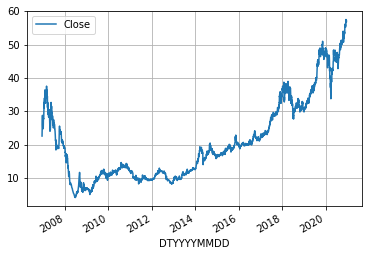

In [12]:
df.plot(grid=True)

#### Tính trung bình theo năm để thấy xu hướng chung

<AxesSubplot:xlabel='DTYYYYMMDD'>

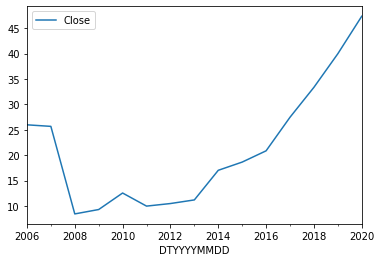

In [13]:
df.resample('Y').mean().plot()

- Nhận xét: Giá đóng cửa có xu hướng giảm và đạt nhỏ nhất vào năm 2008, tăng chậm trở lại trong giai đoạn từ 2010-2016, từ 2017 trở đi có xu hướng tăng, hiện tại đang đạt đỉnh

- Giải thích??

#### Xét giai đoạn gần đây: 2017 - nay

In [14]:
df_new = df.sort_index().loc['20170101':]

<AxesSubplot:xlabel='DTYYYYMMDD'>

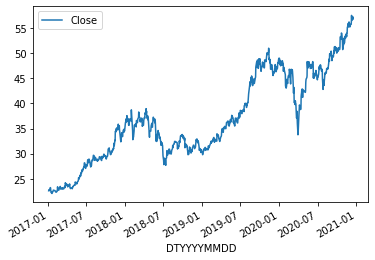

In [15]:
df_new.plot()

- Trending: Nhìn chung có xu hướng tăng, có 2 khoảng thời gian bị giảm bất thường là 07/2018-01/2019 và 01/2020-06/2020

- Giải thích???

#### Box plot

Text(0, 0.5, 'Close Prices')

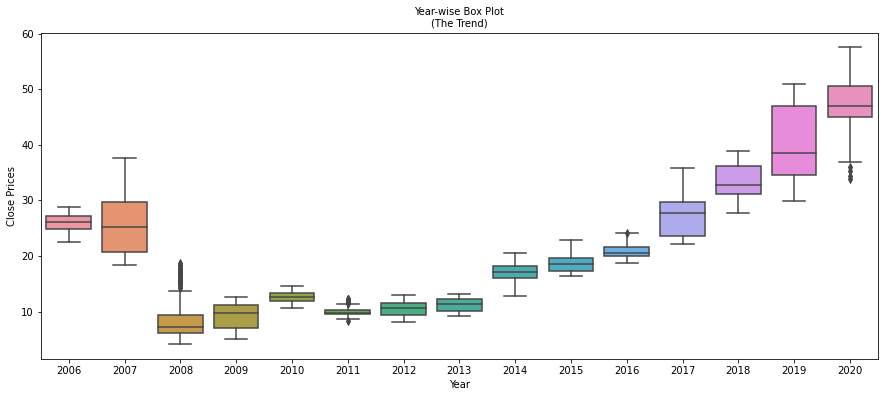

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(df.index.year, df['Close'])
ax.set_title('Year-wise Box Plot\n(The Trend)', fontsize=10, loc='center')
ax.set_xlabel('Year')
ax.set_ylabel('Close Prices')



- Nhận xét: Các năm 2008, 2011, 2016, 2020 có các giá trị bất thường
    - 2008: Cao bất thường
    - 2011: Cao bất thường, thấp bất thường
    - 2016: Cao bất thường
    - 2020: Thấp bất thường

### Seasonal plot 

Mục đích: Tìm hiểu xem giá đóng cửa có bị ảnh hưởng bởi yếu tố mùa vụ (seasonal): tháng trong năm, ngày trong tháng, thứ trong tuần hay ko

#### Monthly box plot

Text(0, 0.5, 'Close Prices')

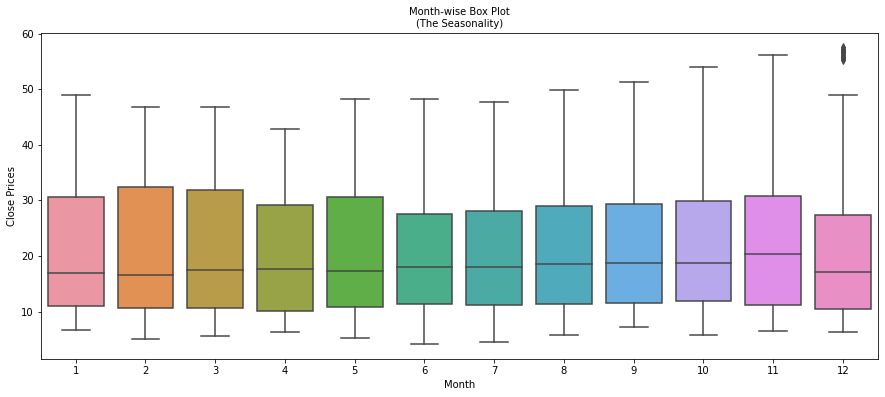

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.boxplot(df.index.month, df['Close'])
ax.set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10, loc='center')
ax.set_xlabel('Month')
ax.set_ylabel('Close Prices')


Nhận xét: Giá đóng cửa có dấu hiệu cao bất thường vào tháng 12

#### Monthly seasonal line plot

In [19]:
df_monthly = df.groupby(pd.Grouper(freq="M")).mean()
years = sorted(set(df_monthly.index.year))
print(years)

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [20]:
year_ranges = [[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], [2015, 2016, 2017, 2018, 2019, 2020]]

monthly_dfs = [df[df.index.year.isin(i)].groupby(pd.Grouper(freq="M")).mean() for i in year_ranges]

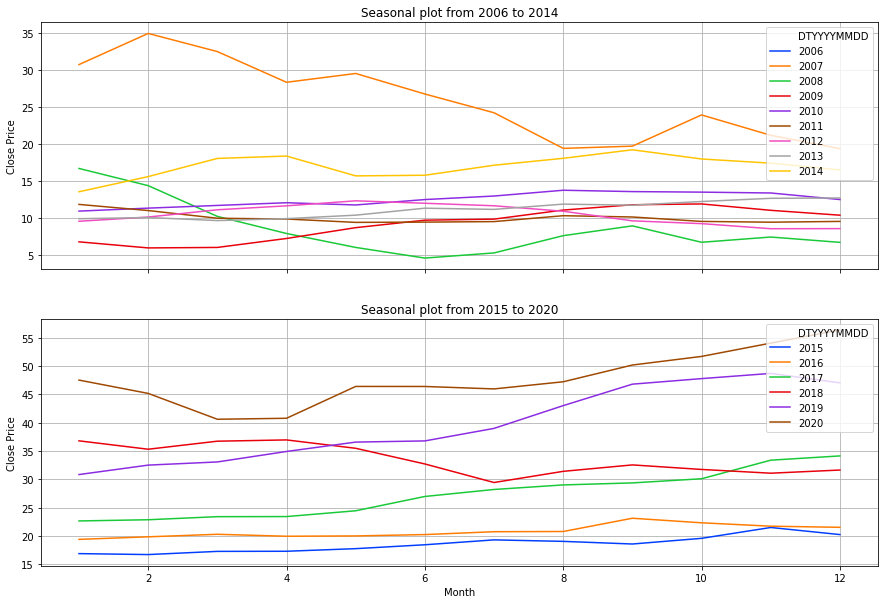

In [21]:
fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True)

for i in range(2):
    sns.lineplot(monthly_dfs[i].index.month, monthly_dfs[i].Close, hue=monthly_dfs[i].index.year, palette='bright', ax=ax[i])
    ax[i].set_title(f'Seasonal plot from {year_ranges[i][0]} to {year_ranges[i][-1]}')
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Close Price')
    ax[i].legend(loc='upper right')
    ax[i].grid()

- Nhận xét: 
    - Giai đoạn 2006 - 2014:
        - Năm 2007 & 2008: bất thường: cao ở đầu năm rồi giảm dần
        - Các năm còn lại có xu hướng ổn định
        
    - Giai đoạn 2015 - 2020:
        - 2015 & 2016: xu hướng ổn định
        - 2017 & 2019: xu hướng tăng dần về cuối năm
        - 2018: Cao ở giữa năm, giảm dần về cuối năm
        - 2020: Giảm ở đầu năm, tăng dần về cuối năm

### ETS 

In [52]:
import statsmodels.tsa.seasonal

In [53]:
df_monthly = df.groupby(pd.Grouper(freq="M")).mean()

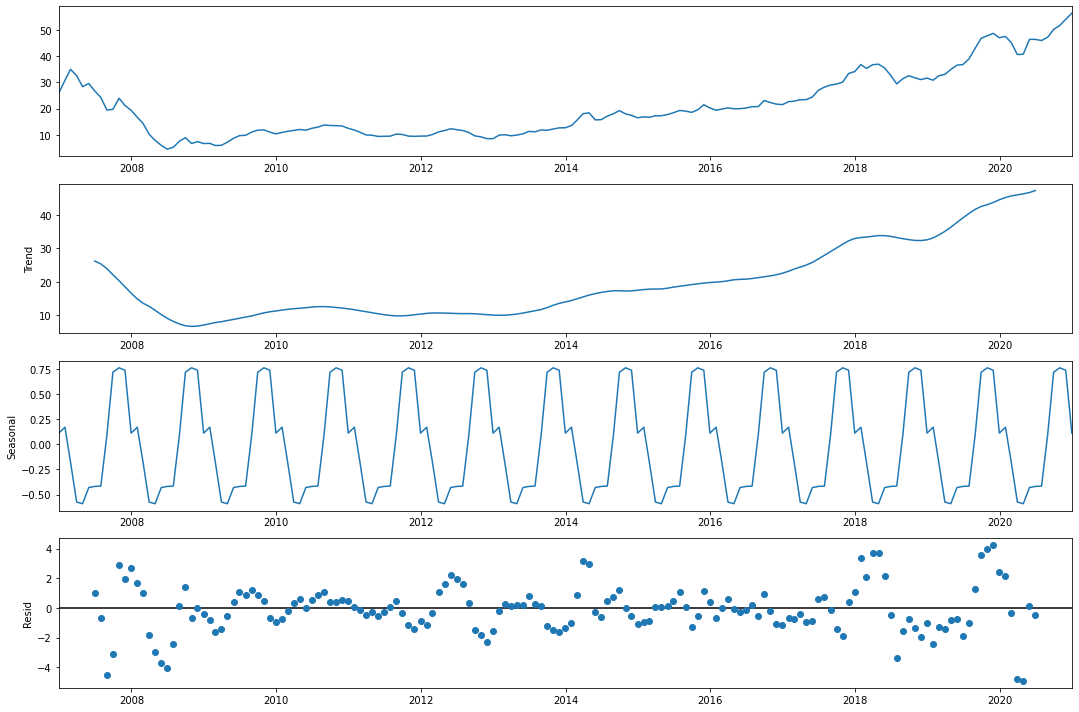

In [55]:
plt.rcParams["figure.figsize"] = (15, 10)

decomposition = statsmodels.tsa.seasonal.seasonal_decompose(df_monthly)
decomposition.plot()
plt.show()

- Giải thích???

## Stationary

- Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. A stationary time series is one whose properties do not depend on the time at which the series is observed.



In [172]:
from statsmodels.tsa.stattools import adfuller


#### ADF test

In [170]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print('Augmented Dickey-Fuller Test: {}'.format(title))
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [27]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.781529
p-value                    0.060961
# lags used               23.000000
# observations          3466.000000
critical value (1%)       -3.432238
critical value (5%)       -2.862374
critical value (10%)      -2.567214
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


- Giải thích??

#### KPSS test

In [31]:
from statsmodels.tsa.stattools import kpss

In [34]:
# KPSS Test
result = kpss(df, regression='c')
print("\nKPSS Statistic: {}".format(result[0]))
print("P-Value: {}".format(result[1]))
for key, value in result[3].items():
    print('Critial Values:')
    print("   {}, {}".format(key,value))



KPSS Statistic: 7.306358378140961
P-Value: 0.01
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/home/vantuan5644/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


- Kết luận?
- Giải thích?

#### Granger Causality test

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests

In [36]:
print(grangercausalitytests(data[['Close', 'Volume']], maxlag=2))



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7645  , p=0.0031  , df_denom=3486, df_num=1
ssr based chi2 test:   chi2=8.7720  , p=0.0031  , df=1
likelihood ratio test: chi2=8.7610  , p=0.0031  , df=1
parameter F test:         F=8.7645  , p=0.0031  , df_denom=3486, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5359  , p=0.0108  , df_denom=3483, df_num=2
ssr based chi2 test:   chi2=9.0848  , p=0.0106  , df=2
likelihood ratio test: chi2=9.0730  , p=0.0107  , df=2
parameter F test:         F=4.5359  , p=0.0108  , df_denom=3483, df_num=2
{1: ({'ssr_ftest': (8.764493082800197, 0.003092222536499182, 3486.0, 1), 'ssr_chi2test': (8.772035675814655, 0.003058838691733343, 1), 'lrtest': (8.76102680843087, 0.0030773574318185815, 1), 'params_ftest': (8.76449394282401, 0.0030922210820981304, 3486.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f87700f5390>, <statsmodels.regression.linear_model.R

- Giải thích?
- Kết luận?

## Autocorrelation plot

In [37]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [196]:
from pandas.plotting import lag_plot


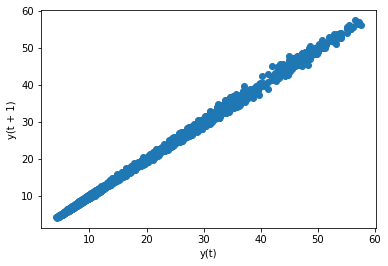

In [203]:
plt.rcParams["figure.figsize"] = (6, 4)

lag_plot(df, lag=1)

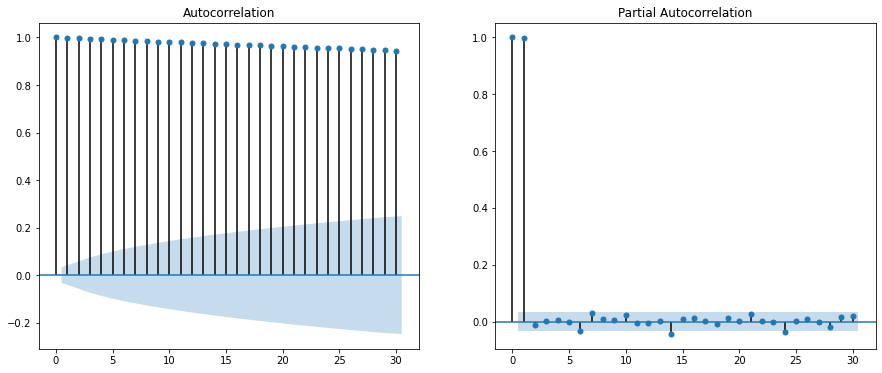

In [258]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
plot_acf(df, lags=30, ax=ax[0])
plot_pacf(df, lags=30, ax=ax[1])
plt.show()

In [206]:
from pandas.plotting import autocorrelation_plot


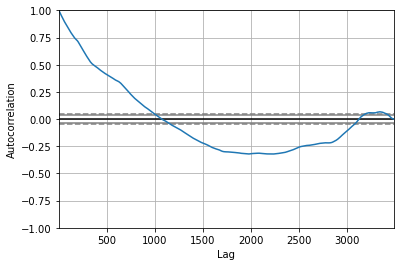

In [207]:
autocorrelation_plot(df)

- Giải thích?
- Kết luận?

## Moving Average

Moving average is the estimation of the trend-cycle at time t, and is obtained by averaging the values of the time series within k periods of t. Observations that are nearby in time are also likely to be close in value. Therefore, the average eliminates some of the randomness in the data, leaving a smooth trend-cycle component.

- The basic SMA has some weaknesses:
    - Smaller windows will lead to more noise, rather than signal.
    - It will always lag by the size of the window.
    - It will never reach the full peak or valley of the data due to the averaging.
    - It does not really inform you about possible future behavior, all it really does is describe trends in your data.
    - Extreme historical values can skew SMA significantly.


#### Simple Moving Average

In [218]:
df = df[['Close']]

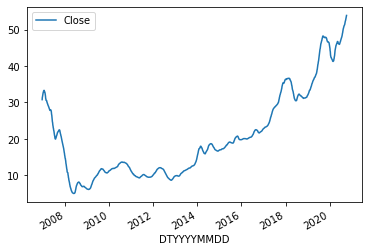

In [220]:
lag = 50
df.rolling(lag).mean().plot()

- Nhận xét?

#### EWMA

In [212]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


#### Double and Triple Exponential Smoothing

In [213]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\tuantv26\Anaconda3\envs\FundaPython\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb


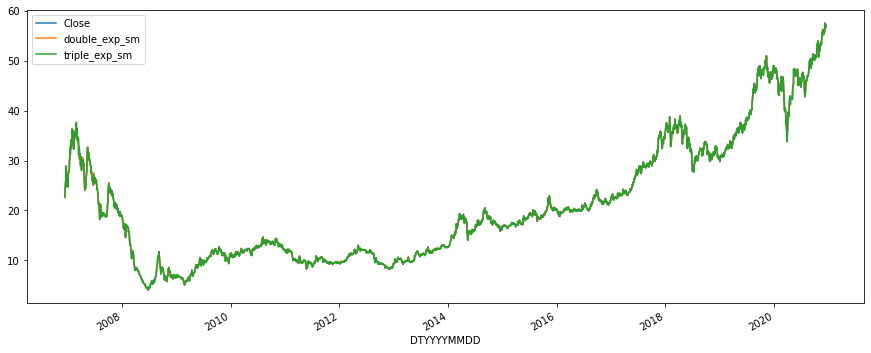

In [260]:
df['double_exp_sm'] = ExponentialSmoothing(df['Close'], trend='add').fit().fittedvalues.shift(-1)
df['triple_exp_sm'] = ExponentialSmoothing(df['Close'], trend='add',seasonal='add', seasonal_periods=7).fit().fittedvalues.shift(-1)
df[['Close', 'double_exp_sm', 'triple_exp_sm']].plot(figsize=(15,6))


## Baseline: ARIMA

### Train test split

In [14]:
def get_data_splits(df, train_ratio: float, validation_ratio: float, test_ratio: float):
    train_len = int(df.shape[0] * train_ratio)
    train_data = df.iloc[: train_len]
    test_len = int(df.shape[0] * test_ratio)
    test_data = df.iloc[-test_len:]
    val_data = df.iloc[train_len:-test_len]
    return train_data, val_data, test_data

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
target_col = 'Close'
df = df[[target_col]].sort_index()
# train_data, _, test_data = get_data_splits(df, train_ratio=0.9, test_ratio=0.1, validation_ratio=0)
train_data, test_data = train_test_split(df, test_size=30, shuffle=False)

print('Train shape: ', train_data.shape)
print('Test shape: ', test_data.shape)


Train shape:  (3460, 1)
Test shape:  (30, 1)


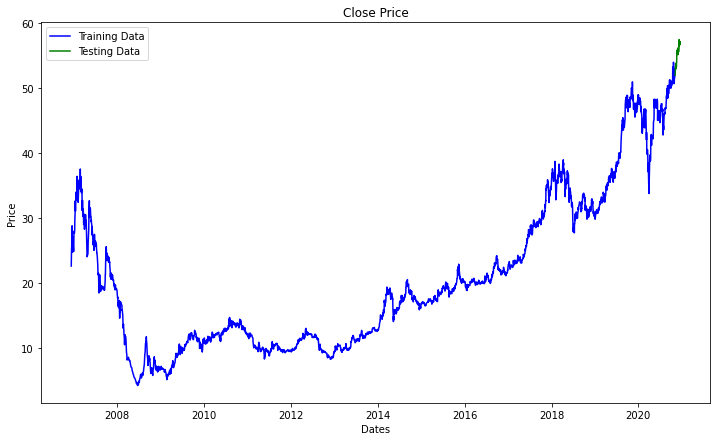

In [17]:
plt.figure(figsize=(12,7))
plt.title('Close Price')
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(train_data[target_col], 'blue', label='Training Data')
plt.plot(test_data[target_col], 'green', label='Testing Data')
plt.legend()


### Min Max scaling

In [18]:
import sklearn.preprocessing


In [19]:
use_feature_scaling = True

In [20]:
if use_feature_scaling:
    train_scaler = sklearn.preprocessing.MinMaxScaler()
    train_data = pd.DataFrame(train_scaler.fit_transform(train_data), columns=train_data.columns, index=train_data.index)
    test_data = pd.DataFrame(train_scaler.transform(test_data), columns=test_data.columns, index=test_data.index)

### Chuyển chuỗi $x_t$ thành chuỗi dừng bằng cách lấy $r_t = \log\left( \frac{r_t}{r_{t-1}} \right)$

- Lí do sử dụng log-return:
    - For the purpose of detrend, I try to analyse returns instead of prices. Then we can get a more stationary time series data.
    - As for practical meaning, people always concentrate on log returns because they are simply eliminate the non-stationary properties of the data set, making the financial data more stable. Here we can plot returns and log returns to see, they are very close to each other at each time point.



In [355]:
r_t = np.log(train_data[target_col] / train_data[target_col].shift(1))

In [161]:
mean = np.nanmean(r_t)
print(mean)
r_t.iloc[0] = mean

0.0002466598307098529


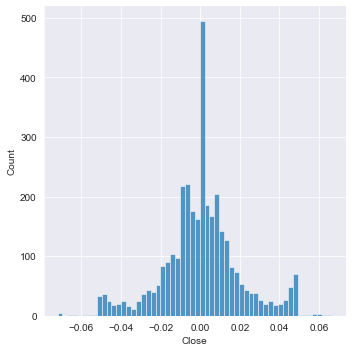

In [165]:
sns.displot(r_t)

Normality test

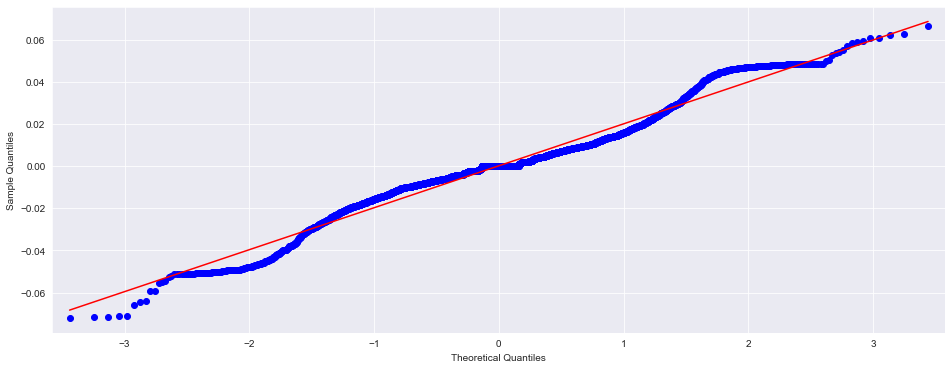

In [166]:
import statsmodels.api as sm
sm.qqplot(r_t, line='s')
plt.show()

In [167]:
from scipy.stats import normaltest

D’Agostino’s K^2 Test


In [168]:
stat, p = normaltest(r_t)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=76.802, p=0.000
Sample does not look Gaussian (reject H0)


Stationary test

In [173]:
adf_test(r_t)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.058470e+01
p-value                 6.763750e-19
# lags used             2.200000e+01
# observations          3.437000e+03
critical value (1%)    -3.432254e+00
critical value (5%)    -2.862381e+00
critical value (10%)   -2.567218e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


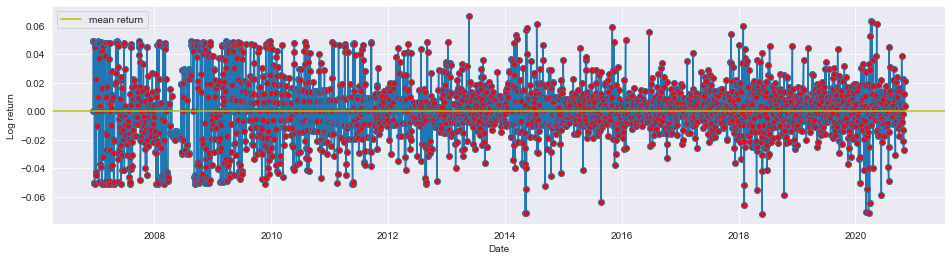

In [174]:
plt.figure(figsize=(16, 4))
plt.plot(r_t, '-o', mfc='r')
plt.axhline(y=mean, label='mean return', c='y')
plt.xlabel('Date')
plt.ylabel('Log return')
plt.legend()
plt.show()

### AutoARIMA

In [175]:
# !pip install pmdarima

In [176]:
# import sys
# sys.executable


In [25]:
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA


#### Fit to the log return $r_t$

In [233]:
stepwise_fit = auto_arima(r_t, start_p=0, start_q=0, 
                          max_p=6, max_q=3,
                          seasonal=False,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                         )
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-17276.273, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17359.185, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-17356.544, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-17357.189, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-17357.181, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-17355.193, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-17357.573, Time=0.15 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 1.182 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3460
Model:               SARIMAX(1, 0, 0)   Log Likelihood                8681.593
Date:                Fri, 25 Dec 2020   AIC                         -17359.185
Time:                        11:21:15   BIC                         -17346.887
Sample:                             0   HQIC                        -17354.794
                               - 3460                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1557      0.011     13.689      0.000       0.133       0.178
sigma2         0.0004   7.56e-06     51.245      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               157.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Đọc và giải thích các tham số??

In [239]:
forecasting_horizon = 7
log_return_pred, conf_interval = stepwise_fit.predict(forecasting_horizon, return_conf_int=True)

In [240]:
def get_x_t(predicted_log_return, last_obs):
    result = np.zeros_like(predicted_log_return)
    
    x_t_prev = last_obs
    for i, r in enumerate(predicted_log_return):
        result[i] = np.exp(r) * x_t_prev
        x_t_prev = result[i]
    return result

In [283]:
y_pred = get_x_t(log_return_pred, last_obs=train_data[target_col].iloc[-1])
print(y_pred)

[55.7328027  55.73791256 55.73870832 55.73883224 55.73885154 55.73885454
 55.73885501]


In [285]:
MAPE(test_data[target_col][:forecasting_horizon], y_pred)

2.0127420777917924

In [242]:
for i in range(conf_interval.shape[1]):
    conf_interval[:, i] = get_x_t(conf_interval[:,i], last_obs=train_data[target_col].iloc[-1])

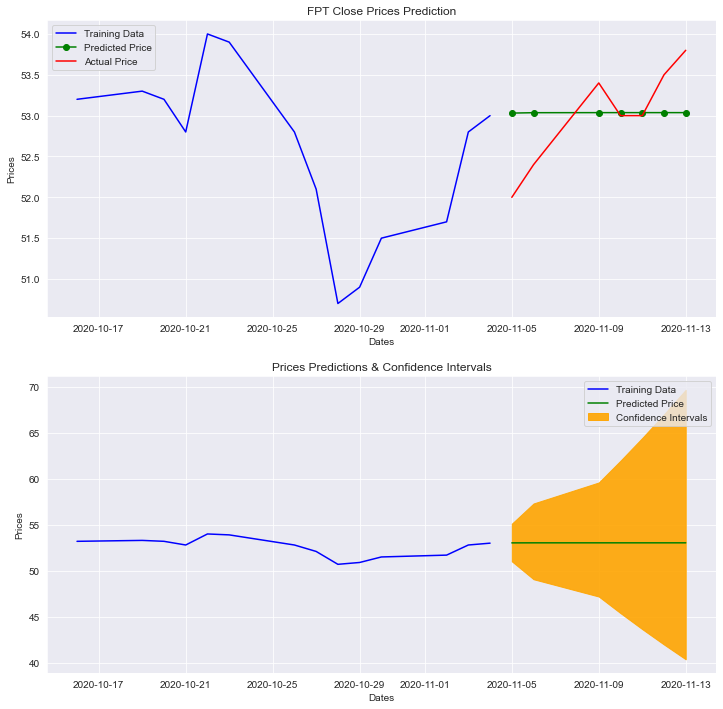

In [243]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_data[target_col][-2 * forecasting_horizon:], color='blue', label='Training Data')
axes[0].plot(test_data.index[:forecasting_horizon], y_pred, color='green', marker='o', label='Predicted Price')

axes[0].plot(test_data.index[:forecasting_horizon], test_data[target_col][:forecasting_horizon], color='red', label='Actual Price')
axes[0].set_title('FPT Close Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_data[target_col][-2 * forecasting_horizon:], color='blue', label='Training Data')
axes[1].plot(test_data.index[:forecasting_horizon], y_pred, color='green', label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_interval)
axes[1].fill_between(test_data.index[:forecasting_horizon],
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()


#### Fit the data direcly

In [356]:
model = auto_arima(train_ts, 
                   start_p=0, start_q=0, max_p=5, max_q=3,
                   seasonal=True, m=1,
                   trace=True,
                   error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-20738.645, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-21541.470, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-21949.354, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-22219.170, Time=0.33 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-22388.498, Time=0.40 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-22466.768, Time=0.40 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-22876.820, Time=1.58 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-22921.289, Time=1.23 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-22924.477, Time=1.00 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-22718.089, Time=0.47 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=1.22 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.32 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-22938.800, Time=1.42 sec
 ARIMA(5,2,2)(0,0,0)[0]   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3460
Model:               SARIMAX(4, 2, 2)   Log Likelihood               11476.400
Date:                Fri, 25 Dec 2020   AIC                         -22938.800
Time:                        15:57:55   BIC                         -22895.761
Sample:                             0   HQIC                        -22923.430
                               - 3460                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8647      0.218     -3.963      0.000      -1.292      -0.437
ar.L2         -0.0112      0.016     -0.684      0.494      -0.043       0.021
ar.L3         -0.0597      0.017     -3.454      0.001      -0.094      -0.026
ar.L4         -0.0122      0.010     -1.193      0.233      -0.032       0.008
ma.L1         -0.0755      0.219     -0.345      0.730      -0.504       0.353
ma.L2         -0.9027      0.216     -4.171      0.000      -1.327      -0.478
sigma2       7.62e-05   8.48e-07     89.856      0.000    7.45e-05    7.79e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              8173.65
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Đọc và giải thích các thông số ???

### Walk forward validation

We will perform the so-called **walk forward validation**. In practice, time series models are re-trained each time a new data becomes available. This allows the model to make the best forecast at each time step. 

Starting at the beginning of the time series, we train the model on the train data set. Then we make a prediction on the next time step. The prediction is then evaluated against the known value. The training set is then expanded to include the known value and the process is repeated. (Note that we keep the training set window fixed, for more efficient training, so every time we add a new observation to the training set, we remove the observation from the beginning of the set.)

This process provides a more robust estimation of how the model will perform in practice. However, it comes at the computation cost of creating so many models. This is acceptable if the data is small or if the model is simple, but could be an issue at scale. 

Walk-forward validation is the gold standard of time series model evaluation and is recommended for your own projects.

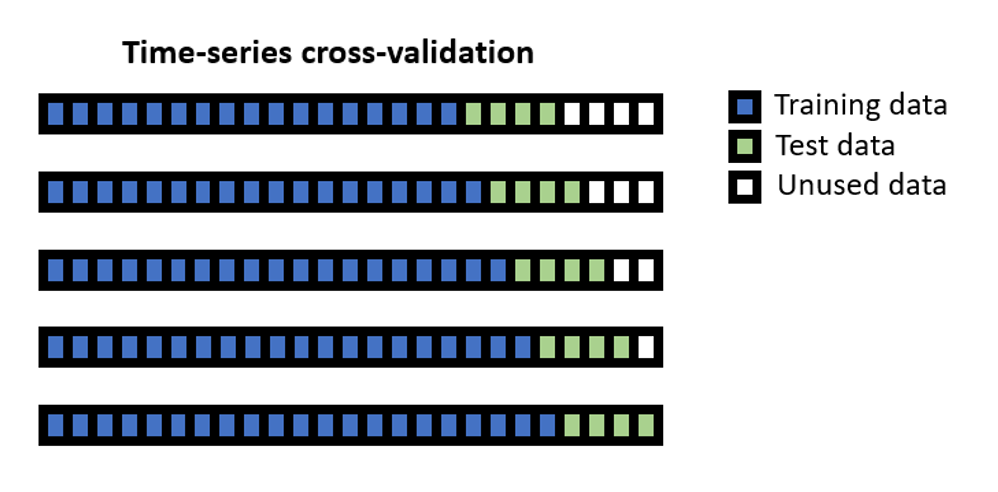

Create a test data point for each HORIZON step.

In [21]:
forecasting_horizon = 7

In [22]:
test_shifted = test_data.copy()

for t in range(1, forecasting_horizon):
    test_shifted[f'{target_col}+{t}'] = test_shifted[target_col].shift(-t)
    
test_shifted = test_shifted.dropna(how='any')
print(test_shifted.shape)
test_shifted.head()


(24, 7)


,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6
DTYYYYMMDD,,,,,,,
2020-11-05,0.959872,0.967897,0.987962,0.979936,0.979936,0.989968,0.995987
2020-11-06,0.967897,0.987962,0.979936,0.979936,0.989968,0.995987,0.985955
2020-11-09,0.987962,0.979936,0.979936,0.989968,0.995987,0.985955,1.000000
2020-11-10,0.979936,0.979936,0.989968,0.995987,0.985955,1.000000,1.000000
2020-11-11,0.979936,0.989968,0.995987,0.985955,1.000000,1.000000,1.022071


Make predictions on the test datatest_shifted

In [23]:
training_window = 500

train_ts = train_data[target_col]
test_ts = test_shifted
history = [x for x in train_ts]
history = history[(-training_window):]

print(len(history), test_ts.shape)


500 (24, 7)


#### Evaluating point forecast 

Each time a new observation come, the model will update itself to have a better point forecast

In [26]:
model = auto_arima(history, 
                   start_p=0, start_q=0, max_p=5, max_q=3,
                   seasonal=True, m=1,
                   trace=True,
                   error_action='ignore', suppress_warnings=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2851.983, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2850.617, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2850.633, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2851.907, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2848.684, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.268 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1427.991
Date:                Fri, 25 Dec 2020   AIC                          -2851.983
Time:                        16:01:15   BIC                          -2843.557
Sample:                             0   HQIC                         -2848.676
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.426      0.154      -0.000       0.002
sigma2         0.0002   7.52e-06     25.453      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               238.02
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               4.33   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
%%time

predictions = []
confidence_intervals = []
order = (0, 1, 0)
# seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order)
    model_fit = model.fit(maxiter=300)
    yhat = model_fit.forecast(steps=forecasting_horizon)
    predictions.append(yhat)
#     print(yhat)
    confidence_intervals.append(model_fit.conf_int())
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
#     print(test_ts.index[t])
#     print(t+1, ': predicted =', yhat, 'expected =', obs)

/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 653 ms, sys: 0 ns, total: 653 ms
Wall time: 651 ms


/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [28]:
eval_df = pd.DataFrame(predictions, columns=['t+' + str(t) for t in range(1, forecasting_horizon + 1)])
eval_df['timestamp'] = test_data.index[:len(test_data.index) - forecasting_horizon + 1]
print(eval_df.shape)

(24, 8)


In [29]:
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = train_scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2020-11-05,t+1,53.0,52.0
1,2020-11-06,t+1,52.0,52.4
2,2020-11-09,t+1,52.4,53.4
3,2020-11-10,t+1,53.4,53.0
4,2020-11-11,t+1,53.0,53.0


In [30]:
eval_df

,timestamp,h,prediction,actual
0,2020-11-05,t+1,53.0,52.0
1,2020-11-06,t+1,52.0,52.4
2,2020-11-09,t+1,52.4,53.4
3,2020-11-10,t+1,53.4,53.0
4,2020-11-11,t+1,53.0,53.0
...,...,...,...,...
163,2020-12-02,t+7,55.2,56.5
164,2020-12-03,t+7,55.6,57.0
165,2020-12-04,t+7,55.6,57.2
166,2020-12-07,t+7,55.7,56.7


In [31]:
if forecasting_horizon > 1:
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual'] * 100
    print(eval_df.groupby('h')['APE'].mean())

h
t+1    0.796530
t+2    1.144846
t+3    1.160975
t+4    1.368437
t+5    1.784962
t+6    2.000178
t+7    2.130708
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (MAPE(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual'])), '%')

One step forecast MAPE:  0.799715677737133 %


In [33]:
print('Multi-step forecast MAPE: ', MAPE(eval_df['prediction'], eval_df['actual']), '%')

Multi-step forecast MAPE:  1.5173366523794445 %


Plot the predictions vs the actuals for the first week of the test set

/home/vantuan5644/anaconda3/envs/StockPriceForecasting/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
No handles with labels found to put in legend.


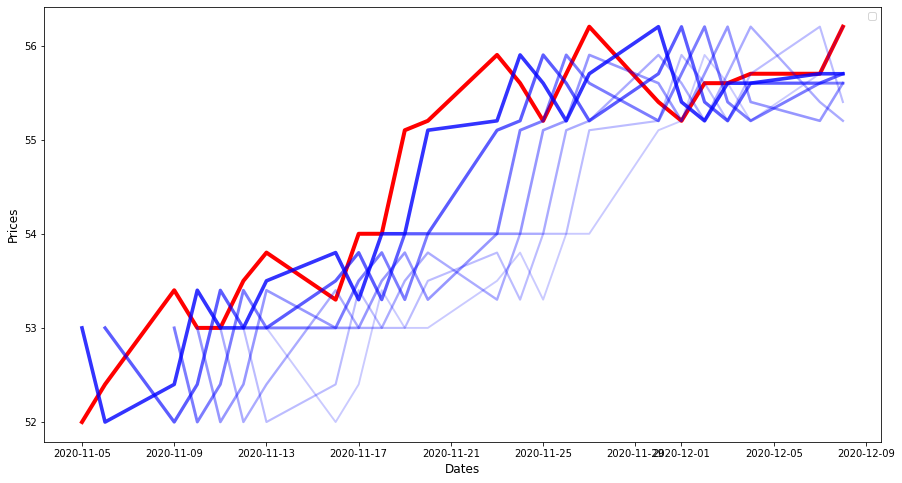

In [34]:
if forecasting_horizon == 1:
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h == 't+1')][['timestamp', 'actual']]
    for t in range(1, forecasting_horizon + 1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, forecasting_horizon + 1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*pow(.9,t), alpha=pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('Dates', fontsize=12)
plt.ylabel('Prices', fontsize=12)
plt.show()

#### Plot diagnostics

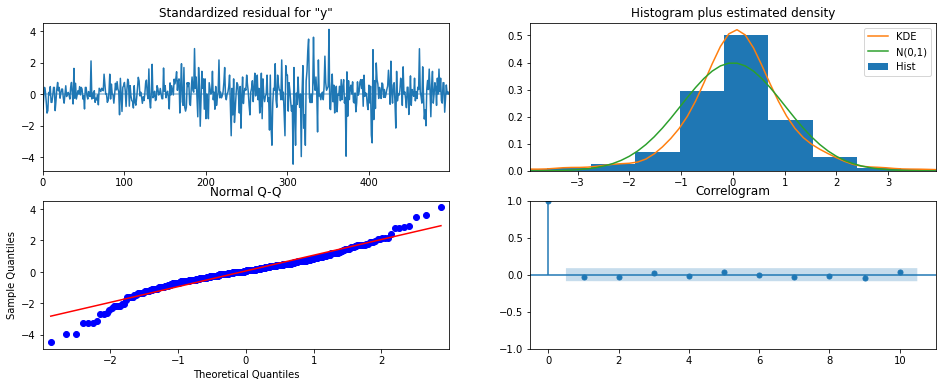

In [47]:
# Define default figure size
# Use plot_predict and visualize forecasts
fig = plt.figure(figsize=(16, 6))
model_fit.plot_diagnostics(fig=fig)
plt.show()

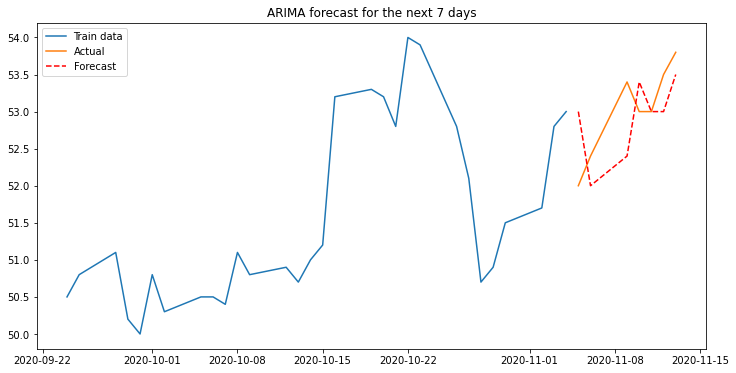

In [45]:
y_pred = eval_df[eval_df.iloc[:, 1] == 't+1']['prediction'].values[:forecasting_horizon]
dates = eval_df[eval_df.iloc[:, 1] == 't+1']['timestamp'][:forecasting_horizon]
y_pred = pd.Series(y_pred, index=dates)

y_true = eval_df[eval_df.iloc[:, 1] == 't+1']['actual'].values[:forecasting_horizon]S
y_true = pd.Series(y_true, index=dates)

# lower = conf_interval[:, 0]
# upper = conf_interval[:, 1]

plt.figure(figsize=(12, 6))
# Plot nearby training data
nearby_training_data = pd.DataFrame(train_scaler.inverse_transform(train_data[target_col][-30:].values.reshape(-1, 1)), index=train_data.index[-30:])
plt.plot(nearby_training_data, label='Train data')
plt.plot(y_true, label='Actual')
plt.plot(y_pred, color='red', linestyle='--', label='Forecast')
# plt.fill_between(dates, lower, upper, color='blue', alpha=0.2)

plt.legend()
plt.title(f'ARIMA forecast for the next {forecasting_horizon} days')
plt.show()
